In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd

### Load data files

All data were downloaded from `weather.gc.ca` using the web API. See `download_can_weather_data.py` for details. I could not quickly find a list of valid station IDs, so I instead iterated over what seemed to be valid station IDs and downloaded all valid files. On inspection, most fields are empty for most of the data files. However, daily temperature and precipitation values are well-populated for some weather stations since 1990-01-01. Some details about these stations' data files are stored in `station_metadata.csv` and the weather data itself is stored in `weather_data.csv`.

The following code can be used to replicate the process to build the two file `station_metadata.csv` and `weather_data.csv` in case updates or additional data from the raw files are needed.

In [2]:
data_dir = "../climate_data"
files = list(os.walk(data_dir))[0][2]
station_list = pd.read_csv("./station_metadata.csv")['STATION_NAME'].tolist()

Iterate over all of the files in the raw data directory, but only retain data with `STATION_NAME` belonging to the those in the `station_list`. Here I'm cheating a bit because I already know which station names have the data I'm looking for. Set `station_list = None` to enable iteration over all data files in the data directory.

In [3]:
all_station_dfs = {}
for f in files:
    try:
        df = pd.read_csv(f"{data_dir}/{f}")
        if station_list is not None:
            if df.STATION_NAME[0] in station_list:
                df.insert(loc=3, column='FILENAME', value=f)
                df = df.set_index("LOCAL_DATE")
                df.index = pd.DatetimeIndex(df.index)
                all_station_dfs[f] = df
        else:
            df.insert(loc=3, column='FILENAME', value=f)
            df = df.set_index("LOCAL_DATE")
            df.index = pd.DatetimeIndex(df.index)
            all_station_dfs[f] = df
    except Exception as e:
        print(f"Error processing {f}")

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (33,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (11,13,15,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (13,15,17,19,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local

Error processing .DS_Store


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (11,23,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (11,13,15,17,19,21,23,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (11,13,15,23,29,31,33,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (11,13,15,17,19,23,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, 

Create dataframe containing station metadata. For this application, we're mainly interested in assessing station locations and data coverage.

In [19]:
all_station_metadata = []
for station_name, df in all_station_dfs.items():
    station_data = {
        'x': df.x[0],
        'y': df.y[0],
        'STATION_NAME': df.STATION_NAME[0],
        'FILENAME': df.FILENAME[0],
        'PROVINCE_CODE': df.PROVINCE_CODE[0],
        'min_date': df.index.min(),
        'max_date': df.index.max(),
        'mean_temp_coverage': 1 - (df.MEAN_TEMPERATURE.isna().sum() / len(df)),
        'max_temp_coverage': 1 - (df.MAX_TEMPERATURE.isna().sum() / len(df)),
        'total_precipitation_coverage': 1 - (df.TOTAL_PRECIPITATION.isna().sum() / len(df)),
        'direction_max_gust_coverage': 1 - (df.DIRECTION_MAX_GUST.isna().sum() / len(df)),
        'speed_max_gust_coverage': 1 - (df.SPEED_MAX_GUST.isna().sum() / len(df)),
        'min_rel_humiudity_coverage': 1 - (df.MIN_REL_HUMIDITY.isna().sum() / len(df)),
        'max_rel_humiudity_coverage': 1 - (df.MAX_REL_HUMIDITY.isna().sum() / len(df)),   
    }
    all_station_metadata.append(pd.Series(station_data))

metadata_df = pd.DataFrame(all_station_metadata)
metadata_df

,x,y,STATION_NAME,FILENAME,PROVINCE_CODE,min_date,max_date,mean_temp_coverage,max_temp_coverage,total_precipitation_coverage,direction_max_gust_coverage,speed_max_gust_coverage,min_rel_humiudity_coverage,max_rel_humiudity_coverage
0,-75.666667,44.600000,BROCKVILLE PCC,station_4236_data.csv,ON,1965-08-01,2022-01-08,0.991571,0.997515,0.997905,0.000000,0.000000,0.000000,0.000000
1,-64.566667,44.533333,CORNWALL,station_6331_data.csv,NS,1950-02-01,1957-01-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2,-124.500278,49.834169,POWELL RIVER A,station_327_data.csv,BC,1954-01-01,2022-01-08,0.981949,0.985930,0.992744,0.000000,0.000000,0.000000,0.000000
3,-97.166667,50.116667,STONY MOUNTAIN,station_3678_data.csv,MB,1972-01-01,2022-01-08,0.997694,0.998032,0.998201,0.000000,0.000000,0.000000,0.000000
4,-82.933333,42.333333,WINDSOR RIVERSIDE,station_4715_data.csv,ON,1866-06-01,2022-01-07,0.952225,0.952405,0.997156,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-110.283333,54.416667,COLD LAKE A,station_2832_data.csv,AB,1952-12-01,2022-01-08,0.999642,0.999642,0.993957,0.919618,0.928205,0.964142,0.964222
126,-125.445556,50.333194,CHATHAM POINT,station_153_data.csv,BC,1958-07-01,2022-01-08,0.999473,0.999617,0.999904,0.000000,0.000000,0.000000,0.000000
127,-64.916667,44.983333,GREENWOOD A,station_6354_data.csv,NS,1942-11-01,2022-01-08,0.999827,0.999862,0.999896,0.831172,0.831380,0.844622,0.844760
128,-74.733333,45.016667,CORNWALL,station_4253_data.csv,ON,1867-01-01,1887-12-31,0.941212,0.941212,0.893579,0.000000,0.000000,0.000000,0.000000


Only select station data with good coverage between 1990 and the present day. 

In [24]:
qualifying_stations = metadata_df.loc[(metadata_df.min_date <= '1990-01-01') & (metadata_df.max_date >= '2022-01-01')]
qualifying_stations.to_csv('station_metadata.csv')
qualifying_stations

,x,y,STATION_NAME,FILENAME,PROVINCE_CODE,min_date,max_date,mean_temp_coverage,max_temp_coverage,total_precipitation_coverage,direction_max_gust_coverage,speed_max_gust_coverage,min_rel_humiudity_coverage,max_rel_humiudity_coverage
0,-75.666667,44.600000,BROCKVILLE PCC,station_4236_data.csv,ON,1965-08-01,2022-01-08,0.991571,0.997515,0.997905,0.000000,0.000000,0.000000,0.000000
2,-124.500278,49.834169,POWELL RIVER A,station_327_data.csv,BC,1954-01-01,2022-01-08,0.981949,0.985930,0.992744,0.000000,0.000000,0.000000,0.000000
3,-97.166667,50.116667,STONY MOUNTAIN,station_3678_data.csv,MB,1972-01-01,2022-01-08,0.997694,0.998032,0.998201,0.000000,0.000000,0.000000,0.000000
4,-82.933333,42.333333,WINDSOR RIVERSIDE,station_4715_data.csv,ON,1866-06-01,2022-01-07,0.952225,0.952405,0.997156,0.000000,0.000000,0.000000,0.000000
6,-77.533333,44.116667,TRENTON A,station_5126_data.csv,ON,1935-01-01,2022-01-08,0.972952,0.974145,0.978690,0.744576,0.748412,0.759341,0.759373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,-93.966667,48.633333,BARWICK,station_3932_data.csv,ON,1978-12-01,2022-01-07,0.975733,0.976396,0.999735,0.000000,0.000000,0.000000,0.000000
125,-110.283333,54.416667,COLD LAKE A,station_2832_data.csv,AB,1952-12-01,2022-01-08,0.999642,0.999642,0.993957,0.919618,0.928205,0.964142,0.964222
126,-125.445556,50.333194,CHATHAM POINT,station_153_data.csv,BC,1958-07-01,2022-01-08,0.999473,0.999617,0.999904,0.000000,0.000000,0.000000,0.000000
127,-64.916667,44.983333,GREENWOOD A,station_6354_data.csv,NS,1942-11-01,2022-01-08,0.999827,0.999862,0.999896,0.831172,0.831380,0.844622,0.844760


### Visualize data coverage for key features

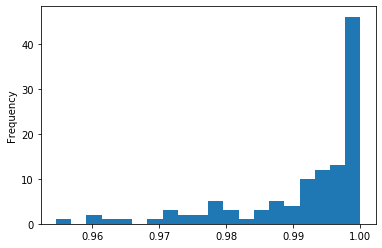

In [25]:
qualifying_stations.total_precipitation_coverage.plot(kind='hist', bins=20)

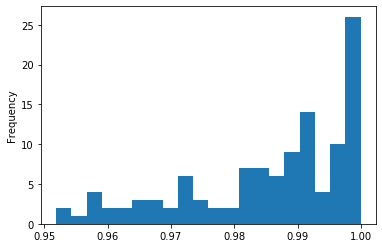

In [26]:
qualifying_stations.mean_temp_coverage.plot(kind='hist', bins=20)

### Build main data frame

For this use case, we're only selecting temperature and total precipitation features since there is very good coverage across the selected stations. A small number of stations have good coverage for additional features, like wind gust speed and direction, but the point of this dataset is to have consistent features across stations.

In [11]:
all_dfs_dict = {}

for filename in qualifying_stations.FILENAME:
    try:
        df = pd.read_csv(f"{data_dir}/{filename}", index_col=5)
        df.index = pd.DatetimeIndex(df.index)
        all_dfs_dict[df['STATION_NAME'][0]] = df
    except Exception as e:
        print(f"Error processing {f}")

keep_columns = [
'MEAN_TEMPERATURE',
'MIN_TEMPERATURE', 
'MAX_TEMPERATURE',
'TOTAL_PRECIPITATION'
]

station_dfs = {}

for station_name, df in all_dfs_dict.items():
    station_dfs[station_name] = df[keep_columns]

data_df = pd.concat(station_dfs, axis=1)
data_df.columns = data_df.columns.to_flat_index()
data_df.columns = [f"{col[0]};{col[1]}" for col in data_df.columns]
data_df = data_df.loc[data_df.index >= '1990-01-01']
data_df.to_csv('./weather_data.csv')
data_df

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (11,13,15,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (33,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/